# This notebook is to perform some initial Exploratory Data Analysis, to create a standard dataset. The idea is not to deviate from that objective here. Further EDA will be done in other notebooks.

In [1]:
import numpy as np
import pandas as pd
import os
from jupyterthemes import jtplot
import datetime as dt
import seaborn as sns
import json

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '/home/miguel/github_repos/python-ds'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')

DATA = os.path.join(DATA_INTERIM, 'data.pkl')
PATHS = os.path.join(DATA_PROCESSED, 'paths.pkl')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC_DIR)

In [2]:
data = pd.read_pickle(DATA)
paths = pd.read_pickle(PATHS)

In [3]:
data.head()

codigoBus linea           timestamp          x          y
0        241  7517 2018-10-02 14:04:37 -56.161850 -34.927967
1        710  7921 2018-10-02 14:04:37 -56.111443 -34.870167
2        961   343 2018-10-02 14:04:37 -56.129030 -34.851887
3         78  2454 2018-10-02 14:04:37 -56.022057 -34.869860
4         15   217 2018-10-02 14:04:37 -56.183617 -34.882000

Is the index unique?

In [4]:
data.index.duplicated().sum()

0

In [5]:
def get_ts(data, feature):
    return data.pivot_table(index='timestamp',
                            values='x',
                            columns='codigoBus')

In [6]:
x_ts = data.pivot_table(index='timestamp',
                        values='x',
                        columns='codigoBus')
y_ts = data.pivot_table(index='timestamp',
                        values='y',
                        columns='codigoBus')

In [7]:
x_ts.shape

(1469, 318)

In [8]:
x_ts.shape[0] * 15 / 3600

6.120833333333334

So, the simulation will take about 6.12 hours (not 3).

In [9]:
data.set_index(['timestamp', 'codigoBus']).T

timestamp 2018-10-02 14:04:37                                               \
codigoBus                 241      710      961      78       15       250   
linea                    7517     7921      343     2454      217     7516   
x                    -56.1619 -56.1114  -56.129 -56.0221 -56.1836 -56.2508   
y                     -34.928 -34.8702 -34.8519 -34.8699  -34.882 -34.8929   

timestamp                                       ...    2018-10-01 19:27:32  \
codigoBus      15       20       29       252   ...                    106   
linea          231     7517      218      873   ...                    217   
x         -56.1893 -56.2303 -56.1607 -56.1938   ...               -56.1657   
y         -34.9058 -34.8693  -34.889 -34.9072   ...               -34.8849   

timestamp                                                                      \
codigoBus  810      823      977      225      77       565      959      28    
linea      266      540      266     7516      217      266     7703     7919   
x            0 -56.2022  -56.138 -56.1519 -56.1769 -56.2004 -56.2008 -56.1095   
y            0 -34.9093 -34.8735 -34.8827 -34.8863 -34.9062 -34.9064 -34.8936   

timestamp           
codigoBus      601  
linea         2392  
x         -56.1072  
y         -34.8946  

[3 rows x 250039 columns]

In [10]:
data.groupby('timestamp').codigoBus.count().describe()

count    1469.000000
mean      170.210347
std        40.595734
min         2.000000
25%       154.000000
50%       187.000000
75%       193.000000
max       203.000000
Name: codigoBus, dtype: float64

In [11]:
data.groupby('timestamp').linea.count().describe()

count    1469.000000
mean      170.210347
std        40.595734
min         2.000000
25%       154.000000
50%       187.000000
75%       193.000000
max       203.000000
Name: linea, dtype: float64

So, the amount of buses and lines change in time

In [12]:
data.linea.unique().shape

(140,)

In [13]:
data.codigoBus.unique().shape

(318,)

In [14]:
data.groupby('linea').codigoBus.unique().head()

linea
1227      [24, 62, 94, 915, 963, 98, 4]
1231        [963, 722, 62, 915, 94, 98]
1237     [89, 907, 1015, 723, 776, 722]
12390        [13, 93, 53, 49, 784, 823]
12391            [784, 13, 49, 823, 93]
Name: codigoBus, dtype: object

In [15]:
data.groupby('linea').codigoBus.apply(lambda x: x.unique().shape[0]).describe()

count    140.000000
mean       8.171429
std        7.448570
min        1.000000
25%        1.000000
50%        7.000000
75%       13.000000
max       33.000000
Name: codigoBus, dtype: float64

It is clear that many different buses serve the same line. Between 1 and 33.

Let's see if any codigoBus is in more than one line

In [16]:
data.groupby('codigoBus').linea.unique().head()

codigoBus
1                     [22425, 2184, 272, 379]
2              [2409, 2408, 1522, 1498, 2440]
3                      [501, 540, 2220, 2408]
4          [343, 340, 2408, 12409, 1227, 540]
5    [7533, 218, 7526, 7529, 217, 2219, 2220]
Name: linea, dtype: object

In [17]:
data.groupby('codigoBus').linea.apply(lambda x: x.unique().shape[0]).describe()

count    318.000000
mean       3.597484
std        2.116838
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       10.000000
Name: linea, dtype: float64

Yes, indeed

Anyway, the reasonable thing to use as an identifier is the "codigoBus", because it should not appear twice in the same timestamp. Or... does it?

In [18]:
t_data = data[data.timestamp == data.timestamp[0]]
print(t_data.shape)
t_data.head()

(192, 5)


codigoBus linea           timestamp          x          y
0        241  7517 2018-10-02 14:04:37 -56.161850 -34.927967
1        710  7921 2018-10-02 14:04:37 -56.111443 -34.870167
2        961   343 2018-10-02 14:04:37 -56.129030 -34.851887
3         78  2454 2018-10-02 14:04:37 -56.022057 -34.869860
4         15   217 2018-10-02 14:04:37 -56.183617 -34.882000

In [19]:
t_data.codigoBus.duplicated().sum()

30

In [20]:
t_data[t_data.codigoBus.duplicated()].sort_values(by='codigoBus')

codigoBus linea           timestamp          x          y
126          5   218 2018-10-02 14:04:37 -56.083134 -34.882217
165          6  7517 2018-10-02 14:04:37 -56.159916 -34.889584
185         10   217 2018-10-02 14:04:37 -56.169033 -34.884167
187         11  2422 2018-10-02 14:04:37 -56.162884 -34.807200
145         13  2391 2018-10-02 14:04:37 -56.136192 -34.872360
6           15   231 2018-10-02 14:04:37 -56.189304 -34.905777
179         20   254 2018-10-02 14:04:37 -56.134525 -34.868280
103         20   218 2018-10-02 14:04:37 -56.183666 -34.883150
24          29  2409 2018-10-02 14:04:37 -56.117832 -34.837640
175         40   517 2018-10-02 14:04:37 -56.136640 -34.806168
119         40   218 2018-10-02 14:04:37 -56.222816 -34.855800
168         50   237 2018-10-02 14:04:37 -56.116722 -34.825554
174         52   340 2018-10-02 14:04:37 -56.133667 -34.859943
133         65  2388 2018-10-02 14:04:37 -56.130066 -34.869865
94          76   217 2018-10-02 14:04:37 -56.161568 -34.888170
151         82   218 2018-10-02 14:04:37 -56.209550 -34.864918
106         88  2391 2018-10-02 14:04:37 -56.195168 -34.905860
56          90   218 2018-10-02 14:04:37 -56.188316 -34.874783
111         90  7919 2018-10-02 14:04:37 -56.156166 -34.884640
173         91   217 2018-10-02 14:04:37 -56.083317 -34.882084
157         99   266 2018-10-02 14:04:37 -56.135640 -34.871887
121         99   217 2018-10-02 14:04:37 -56.222650 -34.855732
104        224  7516 2018-10-02 14:04:37 -56.254185 -34.895500
117        252  7516 2018-10-02 14:04:37 -56.155000 -34.883434
172        288   873 2018-10-02 14:04:37 -56.073223 -34.893387
136        678  1483 2018-10-02 14:04:37   0.000000   0.000000
127        757  7903 2018-10-02 14:04:37 -56.167330 -34.898582
78         907  2391 2018-10-02 14:04:37 -56.198610 -34.906303
162        920   372 2018-10-02 14:04:37 -56.197193 -34.905834
159        956  7703 2018-10-02 14:04:37 -56.200832 -34.906166

In [21]:
t_data.linea.duplicated().sum()

138

In [22]:
t_data[['linea','codigoBus']].duplicated().sum()

0

So, the bus identifier should be made with the tuple (linea, codigoBus). Let's check if that is correct for the rest of the timestamps

In [23]:
data.groupby('timestamp').apply(lambda x: x[['linea','codigoBus']].duplicated().sum()).describe()

count    1469.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

### OK. Let's create the uids

Are the tuples themselves a good uid?

In [24]:
data.head()

codigoBus linea           timestamp          x          y
0        241  7517 2018-10-02 14:04:37 -56.161850 -34.927967
1        710  7921 2018-10-02 14:04:37 -56.111443 -34.870167
2        961   343 2018-10-02 14:04:37 -56.129030 -34.851887
3         78  2454 2018-10-02 14:04:37 -56.022057 -34.869860
4         15   217 2018-10-02 14:04:37 -56.183617 -34.882000

In [30]:
data['uid'] = data.apply(lambda x: '_'.join([str(x.linea), str(x.codigoBus)]), axis=1)
data.head()

codigoBus linea           timestamp          x          y       uid
0        241  7517 2018-10-02 14:04:37 -56.161850 -34.927967  7517_241
1        710  7921 2018-10-02 14:04:37 -56.111443 -34.870167  7921_710
2        961   343 2018-10-02 14:04:37 -56.129030 -34.851887   343_961
3         78  2454 2018-10-02 14:04:37 -56.022057 -34.869860   2454_78
4         15   217 2018-10-02 14:04:37 -56.183617 -34.882000    217_15

In [41]:
def get_line_path(paths, line):
    """ Gets the complete path for a given line. """
    return paths[paths.linea == str(line)]

In [51]:
(paths.linea == line_0.linea[0]).sum()

0

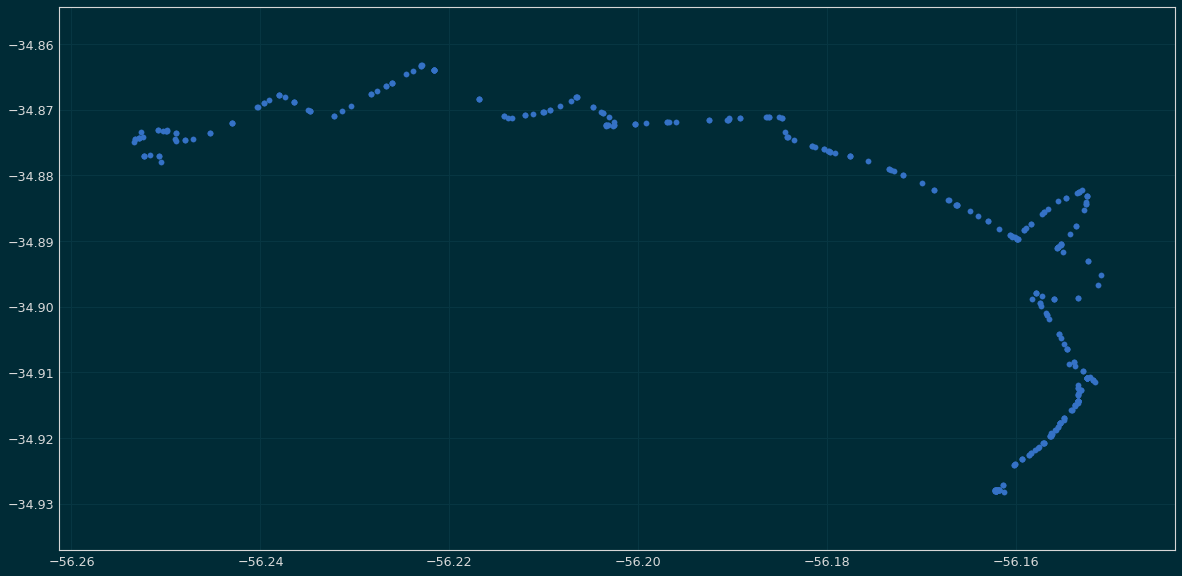

In [45]:
line_0 = data[data.uid == data.uid[0]]
plt.scatter(line_0.x, line_0.y)
path = get_line_path(paths, line_0.linea[0])
plt.plot(path.long, path.lat)

In [55]:
data.timestamp[data.timestamp.apply(lambda x: x.day) == data.timestamp[0].day]

0        2018-10-02 14:04:37
1        2018-10-02 14:04:37
2        2018-10-02 14:04:37
3        2018-10-02 14:04:37
4        2018-10-02 14:04:37
5        2018-10-02 14:04:37
6        2018-10-02 14:04:37
7        2018-10-02 14:04:37
8        2018-10-02 14:04:37
9        2018-10-02 14:04:37
10       2018-10-02 14:04:37
11       2018-10-02 14:04:37
12       2018-10-02 14:04:37
13       2018-10-02 14:04:37
14       2018-10-02 14:04:37
15       2018-10-02 14:04:37
16       2018-10-02 14:04:37
17       2018-10-02 14:04:37
18       2018-10-02 14:04:37
19       2018-10-02 14:04:37
20       2018-10-02 14:04:37
21       2018-10-02 14:04:37
22       2018-10-02 14:04:37
23       2018-10-02 14:04:37
24       2018-10-02 14:04:37
25       2018-10-02 14:04:37
26       2018-10-02 14:04:37
27       2018-10-02 14:04:37
28       2018-10-02 14:04:37
29       2018-10-02 14:04:37
                 ...        
181884   2018-10-02 18:10:28
181885   2018-10-02 18:10:28
181886   2018-10-02 18:10:28
181887   2018-